# Amazon Cell Phone Review - Sentiment Analysis
# using NLP 
Analyzing the Amazon cellphone dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [96]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['title'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

Using Count Vectorizer to create bag of words

In [98]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['verified'].values

In [101]:
import os
import pickle

# Ensure the 'Models' directory exists
os.makedirs('Models', exist_ok=True)

# Now save the CountVectorizer model
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))


Checking the shape of X and y

In [103]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (27203, 2500)
y shape: (27203,)


Splitting data into train and test set with 30% data with testing.

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (19042, 2500)
y train: (19042,)
X test: (8161, 2500)
y test: (8161,)


In [107]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 7
X test max value: 5


We'll scale X_train and X_test so that all values are between 0 and 1.

In [109]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [111]:
import os
import pickle

# Create the 'Models' directory if it doesn't exist
os.makedirs('Models', exist_ok=True)

# Now save the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))


#### Random Forest

In [221]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [223]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9639743724398697
Testing Accuracy : 0.825634113466487


In [225]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [227]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

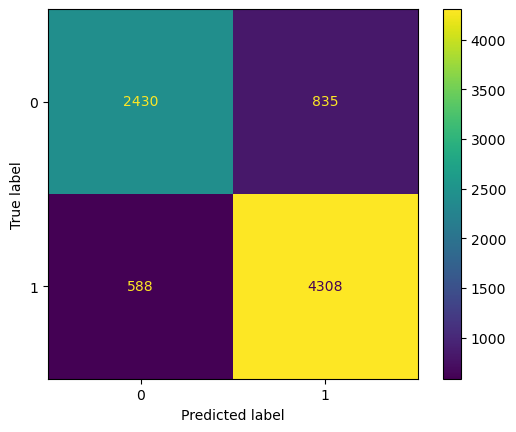

In [229]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K fold cross-validation

In [232]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.8309525188027967
Standard Variance : 0.00874158784654536


Applying grid search to get the optimal parameters on random forest

In [233]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [236]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [238]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 12, 'n_estimators': 100}


In [240]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 89.77982879949586
Cross validation mean accuracy on test set : 81.4357735531982
Accuracy score for test set : 0.825634113466487


#### Decision Tree Classifier

In [242]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [243]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9639743724398697
Testing Accuracy : 0.8008822448229383


In [244]:
y_preds = model_dt.predict(X_test)

In [245]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[2346  919]
 [ 776 4120]]


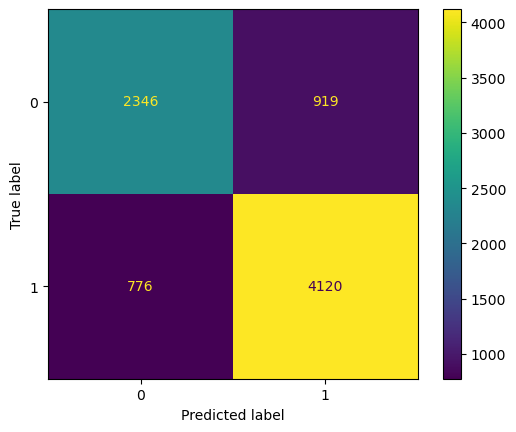

In [246]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

## XgBoost

In [113]:
from xgboost import XGBClassifier
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [115]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.8255435353429261
Testing Accuracy : 0.8110525670873667


In [117]:
y_preds = model_xgb.predict(X_test)

In [119]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[2687  578]
 [ 965 3931]]


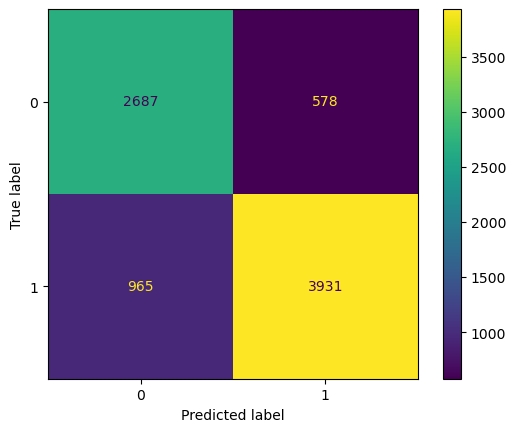

In [121]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [123]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))